In [10]:
# Cell 1: imports & setup
import pandas as pd
import joblib
from pathlib import Path

# Paths
proc_dir  = Path("data/processed")
model_dir = Path("models")

# Load clustered data (with 'clean_joined' & 'cluster')
df = pd.read_parquet(proc_dir / "high_rating_with_clusters.parquet")

# Load LDA model & vectoriser
lda, vec = joblib.load(model_dir / "high_rating_lda.pkl")

# Build document‐term matrix & transform
X = vec.transform(df["clean_joined"].values)
topic_probs = lda.transform(X)            # shape: (n_docs, n_topics)

# Assign dominant topic
df["dominant_topic"] = topic_probs.argmax(axis=1)

# Compute topic prevalence
topic_counts = df["dominant_topic"].value_counts().sort_index()
topic_prevalence = topic_counts / topic_counts.sum()
print("Topic prevalence (% of docs):")
print((topic_prevalence * 100).round(1).astype(str) + "%")

/Users/kevinsoon/Documents/GitHub/thesis_split/.venv/lib/python3.13/site-packages/sklearn/base.py:440: InconsistentVersionWarning: Trying to unpickle estimator LatentDirichletAllocation from version 1.5.1 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/kevinsoon/Documents/GitHub/thesis_split/.venv/lib/python3.13/site-packages/sklearn/base.py:440: InconsistentVersionWarning: Trying to unpickle estimator CountVectorizer from version 1.5.1 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Topic prevalence (% of docs):
dominant_topic
0     9.8%
1    20.7%
2    11.0%
3    16.6%
4     8.1%
5    12.0%
6    11.9%
7     9.9%
Name: count, dtype: object


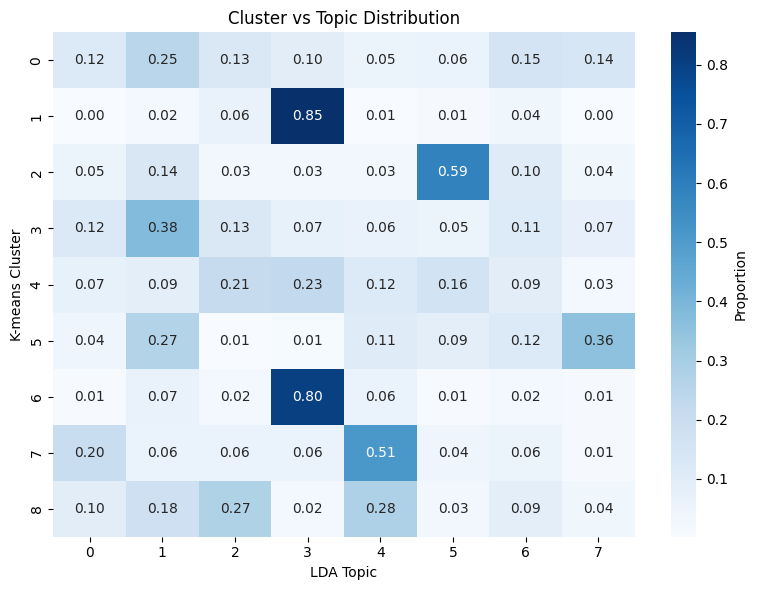

In [11]:
# Cell 2: cross-tab
ct = pd.crosstab(
    df["cluster"],
    df["dominant_topic"],
    normalize="index"           # proportions within each cluster
).round(3)

# Display as a heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
sns.heatmap(ct, annot=True, cmap="Blues", fmt=".2f",
            cbar_kws={"label": "Proportion"})
plt.xlabel("LDA Topic")
plt.ylabel("K-means Cluster")
plt.title("Cluster vs Topic Distribution")
plt.tight_layout()
plt.show()

In [15]:
# Cell 3: pick representative comments per topic
from src.topic_inspection import _NEG_KEYWORDS

examples = {}
for t in sorted(df["dominant_topic"].unique()):
    sub = df[df["dominant_topic"] == t].copy()
    # count how many negative keywords appear
    sub["neg_hits"] = sub["clean_joined"].map(lambda txt: sum(kw in txt for kw in _NEG_KEYWORDS))
    top3 = sub.sort_values("neg_hits", ascending=False).head(3)
    examples[t] = top3[["comment", "clean_joined", "neg_hits"]]
    
# Display them
for t, sample in examples.items():
    print(f"\n=== Topic {t} Examples ===")
    for idx, row in sample.iterrows():
        print(f"- [{row.neg_hits} hits] {row.comment[:120]}…")


=== Topic 0 Examples ===
- [1 hits] 長野県飯田市にある郷土料理店。立地は最悪ですが、料理は一品一品しっかり美味しかったです。ただコスパが悪めでした。春は山菜のシーズンで、松茸や鰻、すっぽんのシーズンがおすすめらしく、また伺い...…
- [1 hits] ここは旨いです。中華の店はたくさん行きますが、旬華なか村さんは中でも独特の個性を放つ異才鬼才の料理人。中村さんご本人は柔和でかなりコミュニケーション能力も高いけど、実は独自の道を進む天才料理人だと...…
- [1 hits] 桂離宮からほど近い地にて開店から40年以上の歴史を刻む、牛肉の聖地と名高い名店…和牛の象徴ともいえるサシについては、健康に育てられた結果入る自然なサシであることが絶対条件と考え、人為的に作られる霜降り...…

=== Topic 1 Examples ===
- [3 hits] 接客最悪、ケーキ美味しくない、高い、待たさせる、もう一度いう、接客最低。お客を見て態度変える。二度といかないし、行かない方がいい。ケーキ不味い。以上。真実です。…
- [3 hits] 雰囲気がいいとの口コミで選びました。長文の後に結論書くより先の方がいいかな。不味い高い遅い。吉野家の逆パターンです。アラカルトで鮑と黄ニラの炒め水ダコの刺身...…
- [2 hits] 完成度が高いのは分かった。平日にもかかわらず常に満席で人気なのも分かった。その上で個人的な好みと照らし合わせると、麺の舌触りがあまり好きではないスープが少し塩辛い煮卵の黄身に味...…

=== Topic 2 Examples ===
- [3 hits] 評判の高い人気店なので前から買いに行きたいと思っていたのですが、なかなか機会がなく、今日が初めての訪問です。だけど残念！夕方遅い時間だったので、ほとんど売り切れ。残っていた2種のパンを購入しました...…
- [2 hits] 比較的小さい店内ですが、ケーキやらチョコレートやら焼き菓子やらたくさんあります。2、３個食べたのですが、見た目もかわいらしく、味もなかなかよく、評価が高いのも納得です。ただ、チーズケーキはそれ...…
- [2 hits] 過去投稿を加筆。ーーー昔からの超有名店、行列苦手だが一度は行かねばと。しかし野菜トッピングしたとはいえ流石に

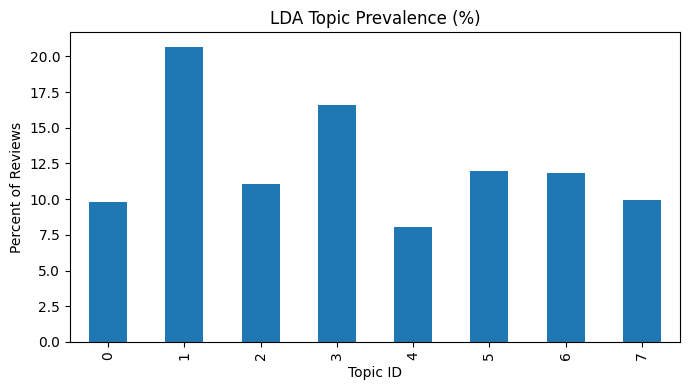

In [17]:
# Cell 4: bar chart of overall topic prevalence
import matplotlib.pyplot as plt

(topic_prevalence * 100).plot.bar(
    figsize=(7,4),
    title="LDA Topic Prevalence (%)",
    xlabel="Topic ID",
    ylabel="Percent of Reviews"
)
plt.tight_layout()
plt.show()

/Users/kevinsoon/Documents/GitHub/thesis_split/.venv/lib/python3.13/site-packages/sklearn/base.py:440: InconsistentVersionWarning: Trying to unpickle estimator LatentDirichletAllocation from version 1.5.1 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/kevinsoon/Documents/GitHub/thesis_split/.venv/lib/python3.13/site-packages/sklearn/base.py:440: InconsistentVersionWarning: Trying to unpickle estimator CountVectorizer from version 1.5.1 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/kevinsoon/Documents/GitHub/thesis_split/.venv/lib/python3.13/site-packages/sklearn/base.py:440: InconsistentVer

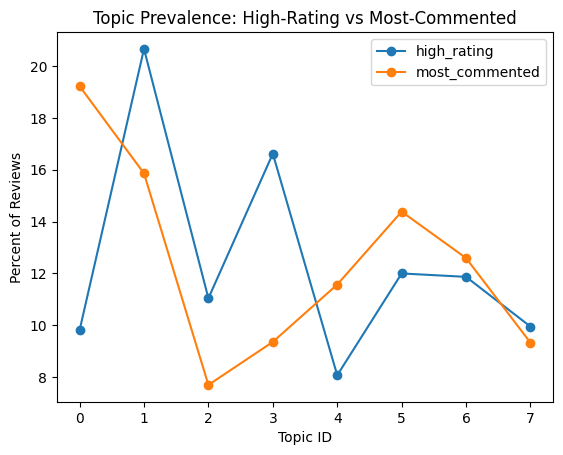

In [19]:
# Cell 5: repeat prevalence for most_commented
for slug in ["high_rating","most_commented"]:
    df2 = pd.read_parquet(proc_dir / f"{slug}_with_clusters.parquet")
    lda2, vec2 = joblib.load(model_dir / f"{slug}_lda.pkl")
    X2 = vec2.transform(df2["clean_joined"].values)
    dom2 = lda2.transform(X2).argmax(axis=1)
    prev = pd.Series(dom2).value_counts(normalize=True).sort_index()
    prev = prev * 100
    plt.plot(prev.index, prev.values, marker="o", label=slug)

plt.xticks(prev.index)
plt.xlabel("Topic ID")
plt.ylabel("Percent of Reviews")
plt.title("Topic Prevalence: High-Rating vs Most-Commented")
plt.legend()
plt.show()